<a href="https://colab.research.google.com/github/maxreynolds/Pattern-Cloud/blob/main/Pattern_FineTuning_and_Inference_SouderNetExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Fine-tuning Workflow

This Notebook is an example of the workflow that Pattern is initially supporting. To train stable diffusion on our user's images, we'll use fine-tuning, which involves taking a pre-trained stable diffusion model and training it further on a new dataset. In this way, we can leverage the knowledge already learned by the pre-trained model and adapt it to the new dataset, allowing us to achieve better performance with less training time.

In [1]:
!nvidia-smi

Sat Oct  7 18:49:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    44W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cd /content/
!git clone https://github.com/huggingface/diffusers.git
!pip install ./diffusers
!pip install -U -r /content/diffusers/examples/text_to_image/requirements.txt
!pip install wandb

Let's configure HuggingFace Accelerate, a platform for allowing us to automatically configure our system to be able to run our training script. You can learn more about Accelerate [here](https://huggingface.co/docs/accelerate/index).

Time to configure our environment variables. For this, we want to tell the script our model name, dataset name, and where we would like it to output the model. We will be automatically pushing the model directly to HuggingFace Hub which will require us to login to our HuggingFace account using the token provided through your HuggingFace account settings.

In [4]:
import os

os.environ['MODEL_NAME'] = f'CompVis/stable-diffusion-v1-2'

os.environ['DATASET_NAME'] = f'MaxReynolds/Lee_Souder_Combined'
os.environ['OUTPUT_DIR'] = f'MaxReynolds/SouderRocketLauncherNetCombined'

In [5]:
from huggingface_hub import notebook_login
notebook_login()

In [6]:
import wandb


In [7]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

Run our training script using HuggingFace accelerate. We'll be inputing our dataset and model with 400 steps (selected) and 134 epochs (default). The model will then be automatically pushed to the hub.

In [3]:
!accelerate config default --mixed_precision fp16

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [25]:
!accelerate launch diffusers/examples/text_to_image/train_text_to_image.py \
  --report_to="wandb" \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$DATASET_NAME \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --mixed_precision="fp16" \
  --max_train_steps=400 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --checkpointing_steps=100000 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --output_dir=$OUTPUT_DIR \
  --validation_prompt="Rocket Launcher by Lee Souder" \
  --push_to_hub \
  --seed=1337


2023-10-07 20:16:56.170668: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/07/2023 20:16:57 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'variance_type', 'thresholding', 'clip_sample', 'clip_sample_range', 'prediction_type', 'sample_max_value', 'dynamic_thresholding_ratio', 'timestep_spacing'} was not found in config. Values will be initialized to default values.
{'force_upcast', 'norm_num_groups', 'scaling_factor'} was not found in config. Values will be initialized to default values.
{'num_class_embeds', 'addition_embed_type_num_heads', 'time_embedding_act_fn', 'time_cond_proj_dim', 'resnet_time_scale_shift', 'conv_out_kernel', 'num_attention_heads', 'encoder_hid_dim', 'addition_embed_type', 'use_linear_projection', 'time_embedding_dim', 'only_cross_attention', 'attention_type', 'resnet_skip_time_act', 'encoder_hid_dim_type', 'time

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/50 [00:00<?, ?it/s]

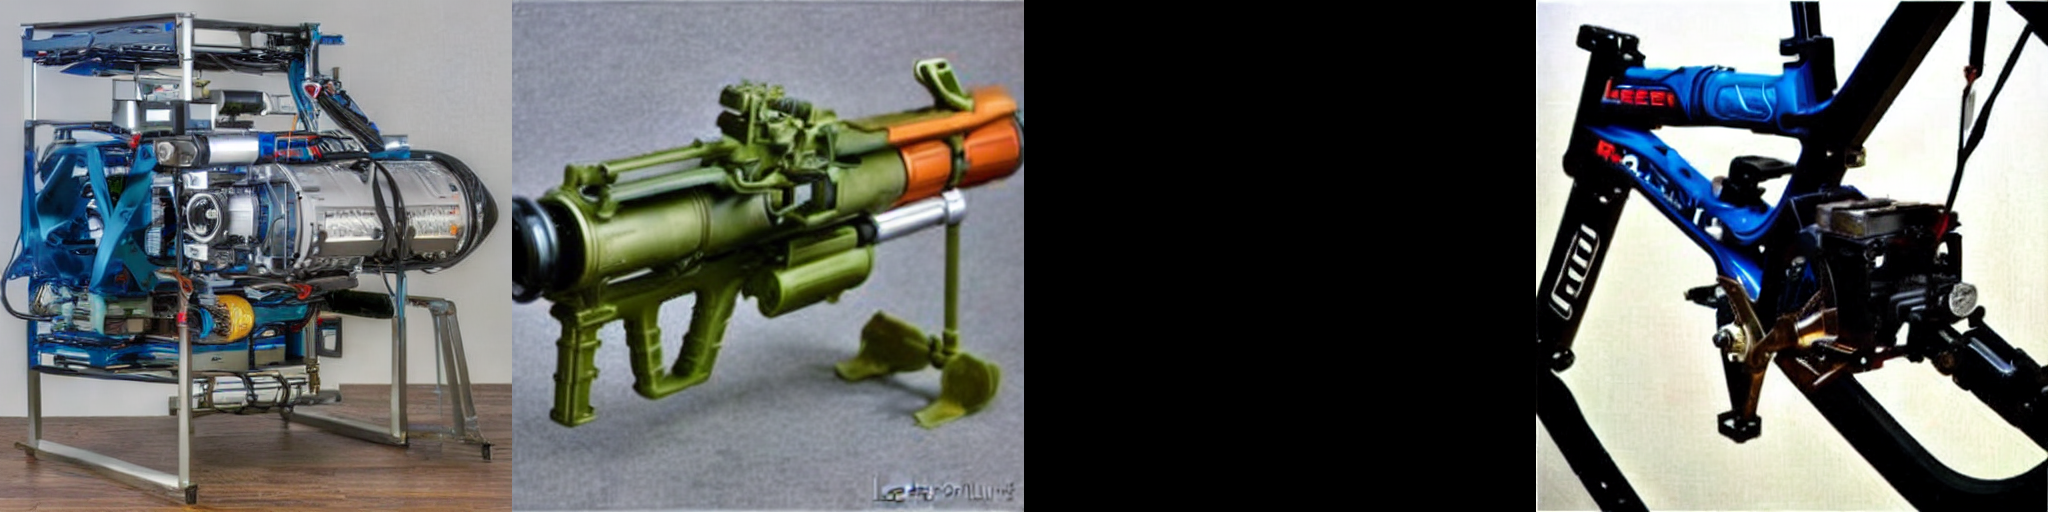

In [26]:
# Let's Run inference on our new model

from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

model_path = "MaxReynolds/SouderRocketLauncherNetCombined"
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

# Run inference using ChatGPT prompts to acquire 4 image panels
image1 = pipe(prompt="Rocket Lancher by Lee Souder").images[0]
image1.save("panel_1.png")

image2 = pipe(prompt="Rocket Launcher by Lee Souder").images[0]
image2.save("panel_2.png")

image3 = pipe(prompt="Raocket Launcher by Lee Souder").images[0]
image3.save("panel_3.png")

image4 = pipe(prompt="Rocket Launcher by Lee Souder").images[0]
image4.save("panel_4.png")

# Image grid helper function from HuggingFace
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

all_images = [image1, image2, image3, image4]
grid = image_grid(all_images, rows=1, cols=4)
grid